# Land cover mapping

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

## 1) U-Net for Land Cover Mapping

Input data are RGB satellite images. And output are images of land cover type. There are 4 land cover types as below,
    - Pixel value 0: background class
    - Pixel value 1: building class
    - Pixel value 2: vegetation/forest class
    - Pixel value 3: water class

In [2]:
'''loading data'''

# data is already randomized and split in to training / test sets. So we can go ahead and use them as it is.
x_train = np.load('./data/x_train.npy').astype('float32')
y_train= np.load('./data/y_train.npy').astype('float32')
x_test = np.load('./data/x_test.npy').astype('float32')
y_test = np.load('./data/y_test.npy').astype('float32') 

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("y_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (70, 128, 128, 3)
y_train shape (70, 128, 128, 1)
y_test shape (30, 128, 128, 3)
y_test shape (30, 128, 128, 1)


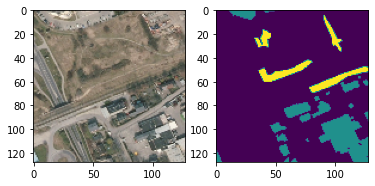

In [3]:
# Let's plot a sample input RGB image and output image with land cover
image_number = random.randint(0, x_test.shape[0])
plt.subplot(121)
plt.imshow(x_test[image_number,:,:,:].astype('uint8'))

plt.subplot(122)
plt.imshow(y_test[image_number,:,:,0].astype('uint8'))
plt.show()

Since land cover data include classes, let's perform one-hot encoding first.

In [4]:
'''one-hot encoding'''

from tensorflow.keras.utils import to_categorical

y_train_1hot = to_categorical(y_train)
y_test_1hot = to_categorical(y_test)

Now, let's define, fit, predict and validate U-Net model for land cover mapping. Here in this example also, we will use same U-Net architecture as in our last example (building mapping). Only different here use of __*softmax*__ activation in the last layer and use of __*cross-entropy*__ loss, because this is a multi-class classification problem.

In [5]:
x_in = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(4, (1, 1), activation='softmax', padding='same')(x_temp)

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

2021-11-26 14:50:03.127323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 14:50:03.128255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 14:50:03.133990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 14:50:03.134913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 14:50:03.135759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [6]:
history = model.fit(x_train, y_train_1hot, validation_data=(x_test, y_test_1hot), epochs=250, batch_size=8, verbose=0)

2021-11-26 14:50:09.844569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-26 14:50:11.662427: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


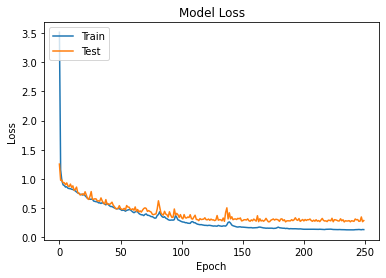

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(30, 128, 128)


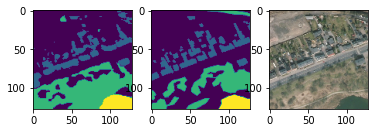

In [8]:
'''Prediction over the test dataset'''
pred_test = model.predict(x_test)

pred_test = np.argmax(pred_test, axis=-1)
print(pred_test.shape)

#let's compare sample predicted and actual land cover image with input RGB image
plt.subplot(131)
plt.imshow(pred_test[12, :, :])
plt.subplot(132)
plt.imshow(y_test[12, :, :, 0])
plt.subplot(133)
plt.imshow(x_test[12,:,:,:].astype('uint8'))
plt.show()

This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.